# Projecto Machine Learning

In [1]:
import matplotlib.pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15, 6)
import numpy as np
import GPy
from OX_database import DissolvedOxygenDatabase
from IPython.display import display
#GPy.plotting.change_plotting_library('plotly')

# Cargar base de datos

In [2]:
path = "/home/rodrigo/ml_prob/DissolvedOxygenPrediction/database/"
sequence_size = 3
train_prop = 0.75
first_day = [2007, 7, 1]

database = DissolvedOxygenDatabase(database_path=path,
                                   sequence_size=3,
                                   train_prop=train_prop,
                                   sequence_batch_size=50,
                                   start_date=first_day)

loading Dissolved_Oxygen
loading Temperature
loading pH
loading Electrical_Conductivity
loading River_Discharge


In [3]:
train_input, train_target, train_days = database.next_batch(batch_size="all")
train_target = train_target[..., np.newaxis]
max_days = float(np.amax(train_days))
train_days = train_days[..., np.newaxis]/max_days
test_input, test_target, test_days = database.next_batch(set="test")
test_target = test_target[..., np.newaxis]
test_days = test_days[..., np.newaxis]/max_days
print(train_target.shape, train_days.shape)

((1661, 1), (1661, 1))


## Relación entre variables

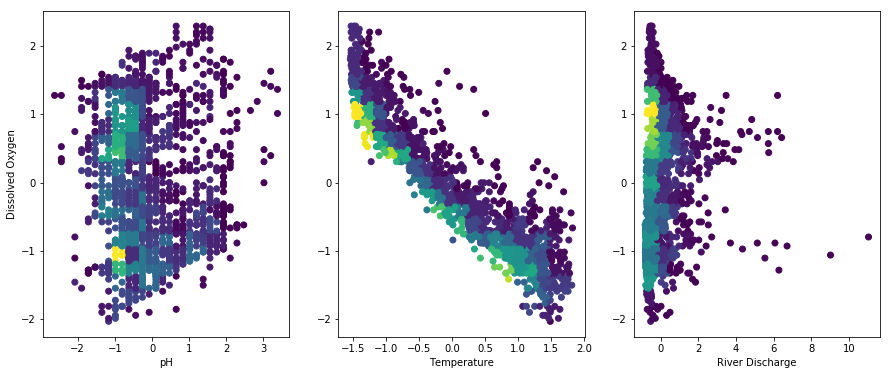

In [4]:
t_target = train_target[:, 0]
n_points = 20

f, axarr = plt.subplots(1,3)
xedges, yedges = np.linspace(np.amin(train_input[:, 0]), np.amax(train_input[:, 0]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 0], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 0], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[0].scatter(train_input[:, 0], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[0].set_xlabel("pH")
axarr[0].set_ylabel("Dissolved Oxygen")

xedges, yedges = np.linspace(np.amin(train_input[:, 1]), np.amax(train_input[:, 1]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 1], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 1], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[1].scatter(train_input[:, 1], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[1].set_xlabel("Temperature")

xedges, yedges = np.linspace(np.amin(train_input[:, 2]), np.amax(train_input[:, 2]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 2], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 2], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[2].scatter(train_input[:, 2], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[2].set_xlabel("River Discharge")
plt.show()

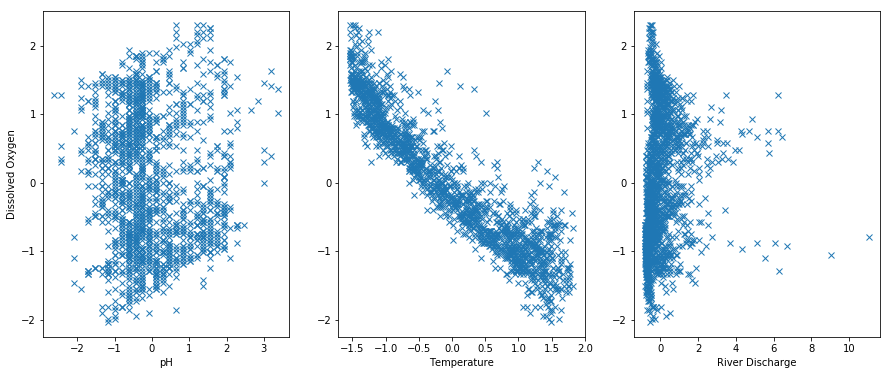

In [5]:
t_target = train_target[:, 0]

f, axarr = plt.subplots(1,3)
axarr[0].plot(train_input[:, 0], t_target, 'x')
axarr[0].set_xlabel("pH")
axarr[0].set_ylabel("Dissolved Oxygen")

axarr[1].plot(train_input[:, 1], t_target, 'x')
axarr[1].set_xlabel("Temperature")

axarr[2].plot(train_input[:, 2], t_target, 'x')
axarr[2].set_xlabel("River Discharge")
plt.show()

## Kernel exponencial

In [6]:
kernel = GPy.kern.RBF(input_dim=1)

In [7]:
m = GPy.models.GPRegression(train_days, train_target, kernel)

 /usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


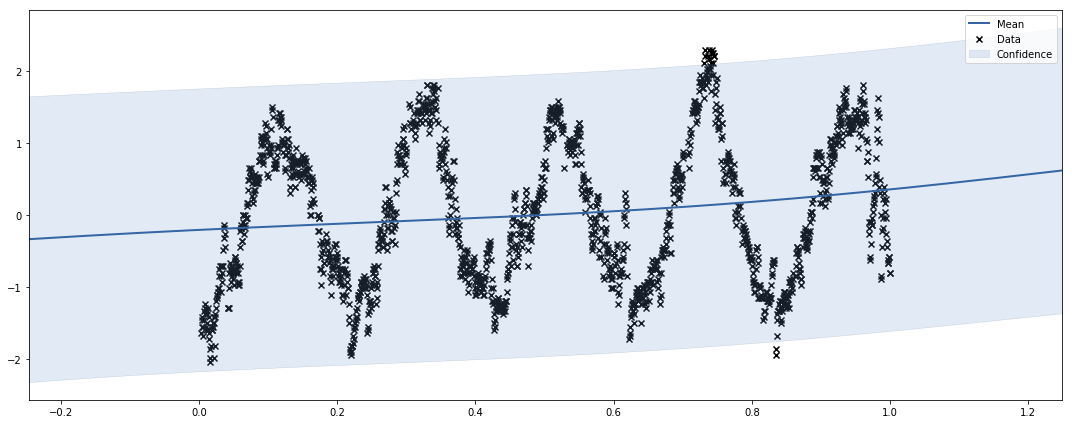

In [8]:
# +- 2 std 
fig = m.plot()
GPy.plotting.show(fig, filename='exponential_bopt')
#plt.xlim([np.amin(train_days), np.amax(train_target)])

In [9]:
m.optimize(messages=True)

 /usr/local/lib/python2.7/dist-packages/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square


In [10]:
m.optimize_restarts(num_restarts=3)

Optimization restart 1/3, f = -440.497992294
Optimization restart 2/3, f = -440.497992294
Optimization restart 3/3, f = -440.497992294


GP_regression.,value,constraints,priors
rbf.variance,0.570308158161,+ve,
rbf.lengthscale,0.00193147773126,+ve,
Gaussian_noise.variance,0.00731667209327,+ve,


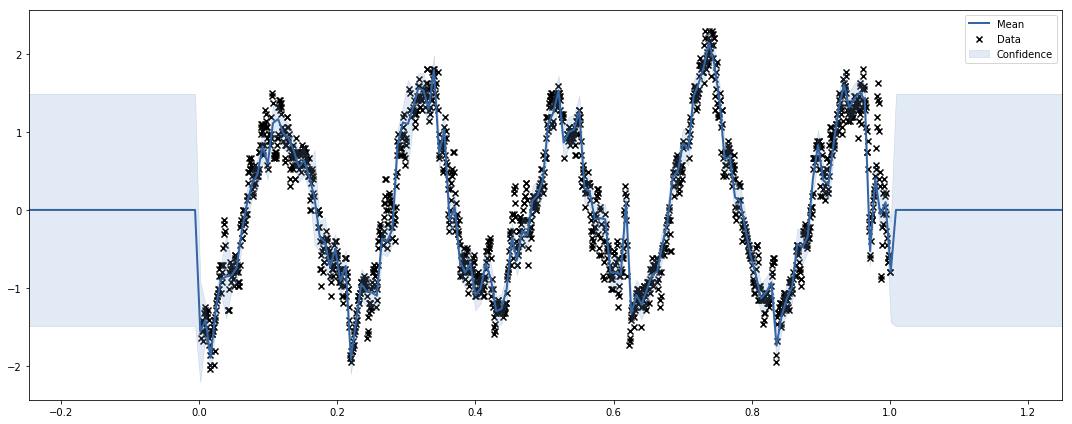

In [11]:
display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='exponential_aopt')

## Periodic Kernel

In [12]:
periodic_kernel = GPy.kern.PeriodicExponential(input_dim=1, period=0.3)

In [13]:
periodic_model = GPy.models.GPRegression(train_days, train_target, periodic_kernel)

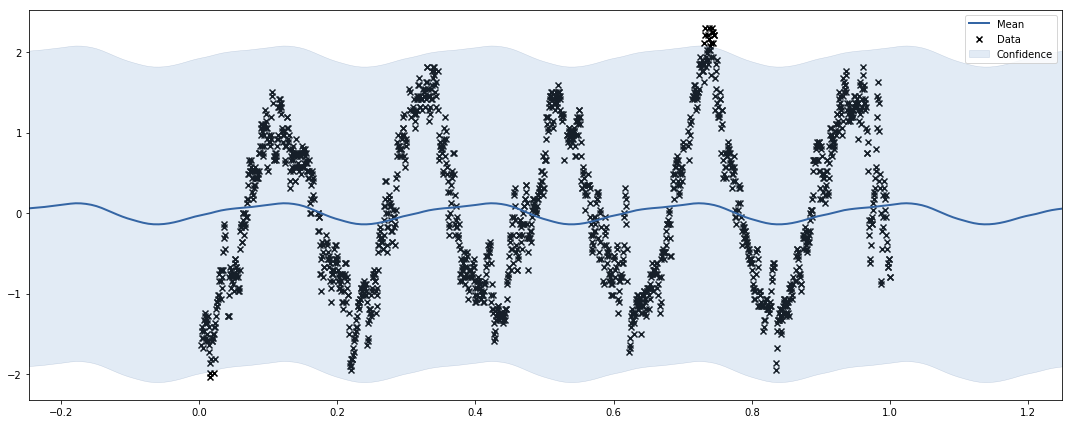

In [14]:
# +- 2 std 
fig = periodic_model.plot()
GPy.plotting.show(fig, filename='periodic_before')
#plt.xlim([np.amin(train_days), np.amax(train_target)])

In [15]:
periodic_model.optimize_restarts(num_restarts=3)

Optimization restart 1/3, f = 450.247547497
Optimization restart 2/3, f = 513.37032955
Optimization restart 3/3, f = 497.601969574


GP_regression.,value,constraints,priors
periodic_exponential.variance,7666.83721954,+ve,
periodic_exponential.lengthscale,25.9447023823,+ve,
periodic_exponential.period,0.411280402526,+ve,
Gaussian_noise.variance,0.0946454552543,+ve,


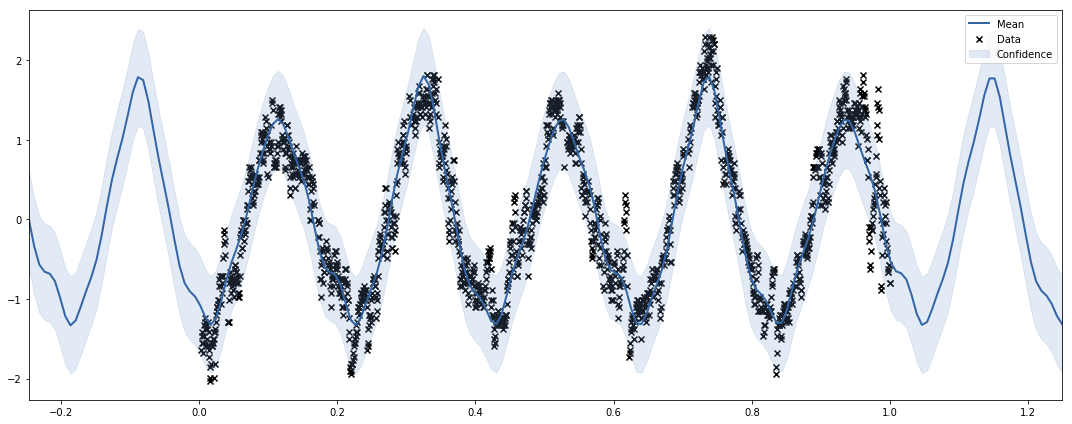

In [16]:
display(periodic_model)
fig = periodic_model.plot()
GPy.plotting.show(fig, filename='periodic_after')

In [17]:
display(periodic_kernel)

periodic_exponential.,value,constraints,priors
variance,7666.83721954,+ve,
lengthscale,25.9447023823,+ve,
period,0.411280402526,+ve,


In [18]:
def plot_mean_std(x, mean, std, real):
    fig = plt.figure()
    print(x.shape)
    print(mean.shape)
    print(std.shape)
    plt.plot(x, mean, "b", label = "Mean")
    mean = np.reshape(mean, (mean.shape[0],))
    x = np.reshape(x, (x.shape[0],))
    std = np.reshape(std, (std.shape[0],))
    real = np.reshape(real, (std.shape[0],))
    plt.fill_between(x, mean+2*std, mean-2*std, alpha = 0.3)
    plt.plot(x, real, 'x')
    plt.show()

(563, 1)
(563, 1)
(563, 1)


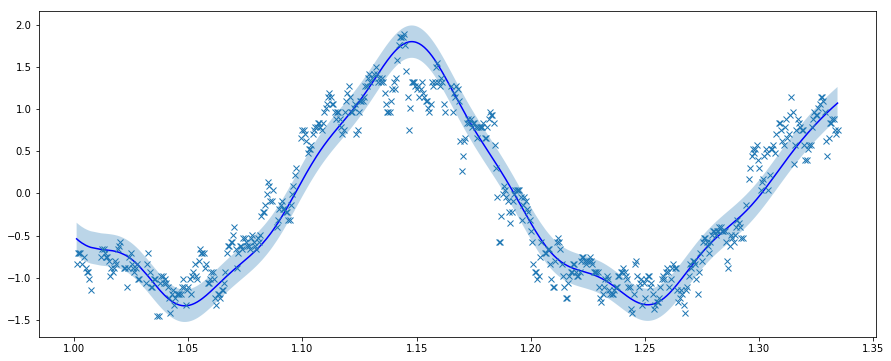

In [35]:
mu, var = periodic_model.predict(test_days)
plot_mean_std(test_days, mu, var, test_target)

## Sum of periodic kernels

In [20]:
def sum_periodic_kernel(n_kernels=5):
    k = GPy.kern.PeriodicExponential(input_dim=1)
    for i in range(n_kernels-1):
        k += GPy.kern.PeriodicExponential(input_dim=1)
    return k

In [21]:
sum_periodic = sum_periodic_kernel(5)

In [22]:
display(sum_periodic)

sum.,value,constraints,priors
periodic_exponential.variance,1.0,+ve,
periodic_exponential.lengthscale,1.0,+ve,
periodic_exponential.period,6.28318530718,+ve,
periodic_exponential_1.variance,1.0,+ve,
periodic_exponential_1.lengthscale,1.0,+ve,
periodic_exponential_1.period,6.28318530718,+ve,
periodic_exponential_2.variance,1.0,+ve,
periodic_exponential_2.lengthscale,1.0,+ve,
periodic_exponential_2.period,6.28318530718,+ve,
periodic_exponential_3.variance,1.0,+ve,


In [23]:
sum_periodic_model = GPy.models.GPRegression(train_days, train_target, sum_periodic)

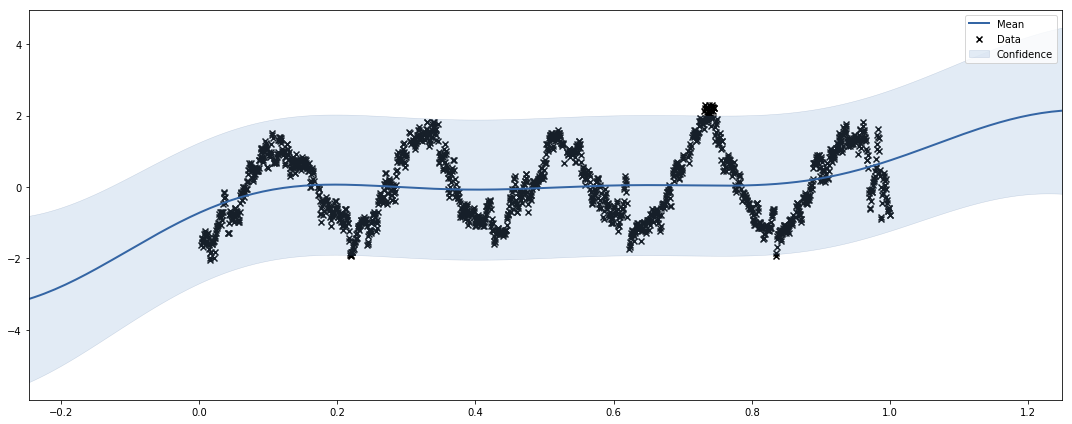

In [24]:
# +- 2 std 
fig = sum_periodic_model.plot()
GPy.plotting.show(fig, filename='sum_periodic')
#plt.xlim([np.amin(train_days), np.amax(train_target)])

In [25]:
sum_periodic_model.optimize_restarts(num_restarts=2)

Optimization restart 1/2, f = 559.256194198
Optimization restart 2/2, f = 301.358685812


GP_regression.,value,constraints,priors
sum.periodic_exponential.variance,1.01066618786,+ve,
sum.periodic_exponential.lengthscale,0.0218785901837,+ve,
sum.periodic_exponential.period,0.895708330091,+ve,
sum.periodic_exponential_1.variance,84.7581526929,+ve,
sum.periodic_exponential_1.lengthscale,0.00151443404457,+ve,
sum.periodic_exponential_1.period,1.96146338988,+ve,
sum.periodic_exponential_2.variance,56.323265578,+ve,
sum.periodic_exponential_2.lengthscale,0.00227008610283,+ve,
sum.periodic_exponential_2.period,1.96157943072,+ve,
sum.periodic_exponential_3.variance,25.0006584645,+ve,


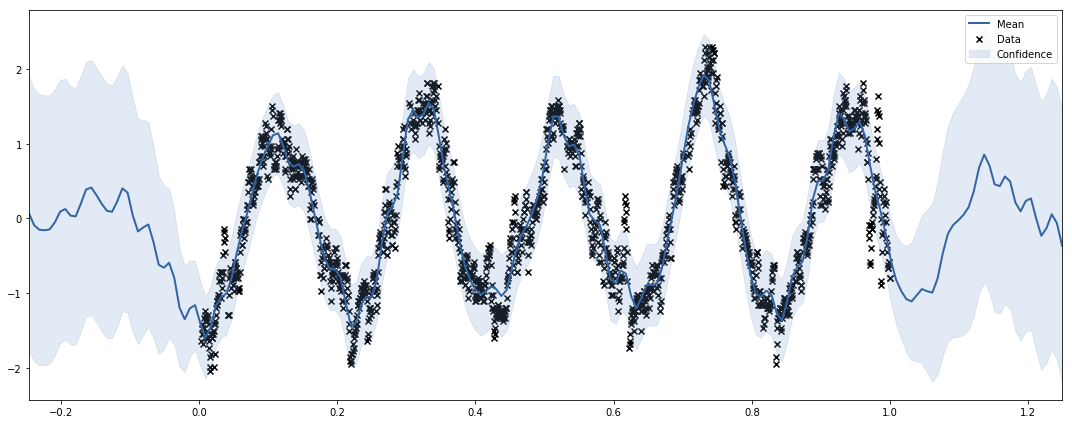

In [26]:
display(sum_periodic_model)
fig = sum_periodic_model.plot()
GPy.plotting.show(fig, filename='sum_periodic_after')

(563, 1)
(563, 1)
(563, 1)


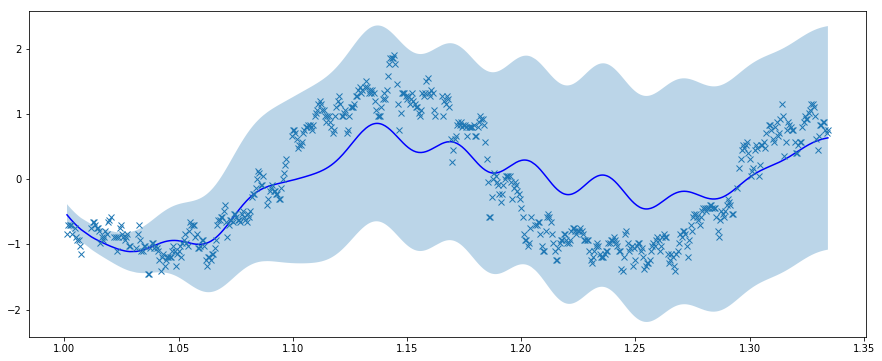

In [34]:
mu, var = sum_periodic_model.predict(test_days)
plot_mean_std(test_days, mu, var, test_target)

## Locally periodic kernel

In [28]:
locally_periodic_kernel = GPy.kern.Exponential(input_dim=1) * GPy.kern.PeriodicExponential(input_dim=1)
display(locally_periodic_kernel)

mul.,value,constraints,priors
Exponential.variance,1.0,+ve,
Exponential.lengthscale,1.0,+ve,
periodic_exponential.variance,1.0,+ve,
periodic_exponential.lengthscale,1.0,+ve,
periodic_exponential.period,6.28318530718,+ve,


In [29]:
locally_periodic_model = GPy.models.GPRegression(train_days, train_target, locally_periodic_kernel)

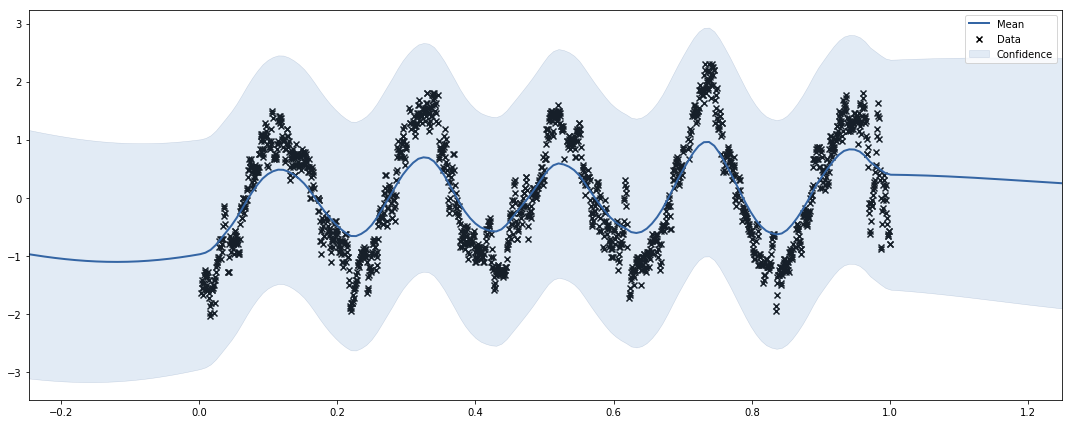

In [30]:
# +- 2 std 
fig = locally_periodic_model.plot()
GPy.plotting.show(fig, filename='locally_periodic_before')
#plt.xlim([np.amin(train_days), np.amax(train_target)])

In [31]:
locally_periodic_model.optimize_restarts(num_restarts=3)

Optimization restart 1/3, f = -808.69298902
Optimization restart 2/3, f = -812.134373458
Optimization restart 3/3, f = -810.210276672


GP_regression.,value,constraints,priors
mul.Exponential.variance,12.3190069438,+ve,
mul.Exponential.lengthscale,0.0506383416281,+ve,
mul.periodic_exponential.variance,12.8655746745,+ve,
mul.periodic_exponential.lengthscale,0.00298088123178,+ve,
mul.periodic_exponential.period,11.614055391,+ve,
Gaussian_noise.variance,3.3181290497e-07,+ve,


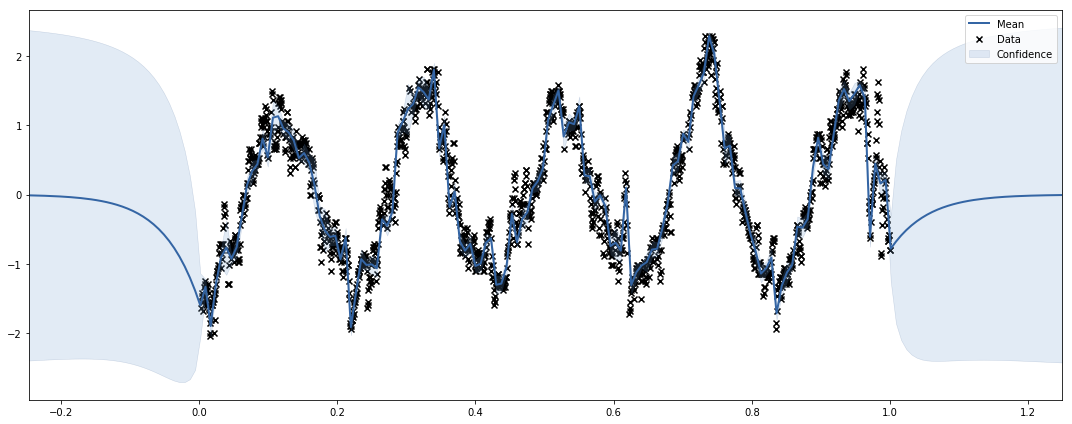

In [32]:
display(locally_periodic_model)
fig = locally_periodic_model.plot()
GPy.plotting.show(fig, filename='locally_periodic_after')